In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission_example = pd.read_csv('submission.csv')

Ideas -- we know that infections rates are logorithmic, we can fit each region specifically then use the test data see what path it follows best (min residuals or something?).

Alternatively, we can look at SIR (suseptable, infected, recovered) models, which is a modern take on infection modeling.

In [9]:
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [8]:
train.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,17324.000000,17324.000000,17324.000000,17324.000000,17324.000000
mean,13190.500000,26.287693,4.766191,293.191180,10.421208
std,7624.680783,22.935113,79.923334,3382.665468,155.612328
min,1.000000,-41.454500,-157.498300,0.000000,0.000000
25%,6595.750000,13.145425,-71.516375,0.000000,0.000000
50%,13190.500000,32.985550,9.775000,0.000000,0.000000
75%,19785.250000,42.501575,64.688975,8.000000,0.000000
max,26380.000000,71.706900,174.886000,67800.000000,5476.000000


Text(0.5, 0, 'Date')

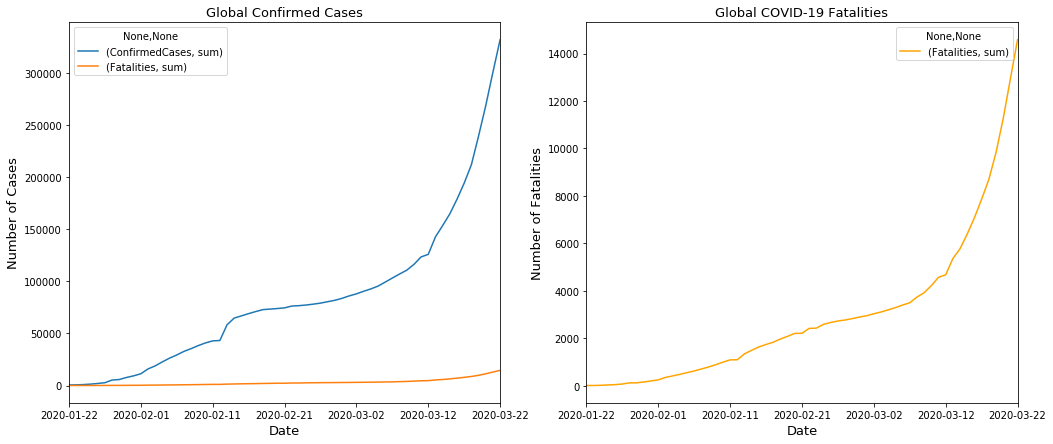

In [17]:
confirmed_total_by_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatality_total_by_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_by_date = confirmed_total_by_date.join(fatality_total_by_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,7))
total_by_date.plot(ax = ax1)
ax1.set_title('Global Confirmed Cases and Fatalities', size = 13)
ax1.set_ylabel('Number of Cases', size = 13)
ax1.set_xlabel('Date', size = 13)
fatality_total_by_date.plot(ax = ax2, color = 'Orange')
ax2.set_title('Global COVID-19 Fatalities', size = 13)
ax2.set_ylabel('Number of Fatalities', size = 13)
ax2.set_xlabel('Date', size = 13)

A couple toughts re China.  Since they were the initial location for the outbreak, they had a delayed response.  Also, given the current political environment there with respect to reporting suppression, I do not know if their reported values are true.  I will remove China for a second and see if that smooths out the plot.

Specified provinces in China:  ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']


Text(0.5, 0, 'Date')

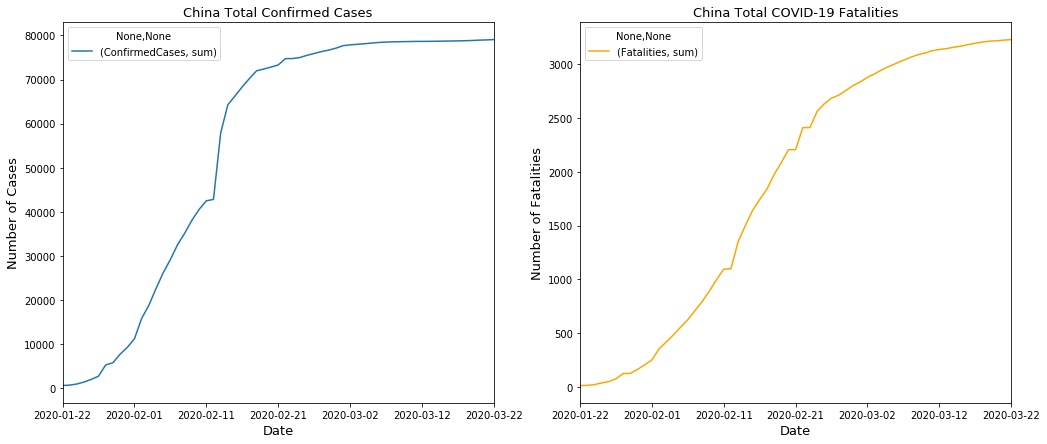

In [24]:
#  Just looking at China data
train_china = train[train['Country/Region'] == 'China']
print('Specified provinces in China: ', train_china['Province/State'].unique())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,7))
train_china.groupby(['Date']).agg({'ConfirmedCases':['sum']}).plot(ax = ax1)
ax1.set_title('China Total Confirmed Cases', size = 13)
ax1.set_ylabel('Number of Cases', size = 13)
ax1.set_xlabel('Date', size = 13)
train_china.groupby(['Date']).agg({'Fatalities':['sum']}).plot(ax = ax2, color = 'Orange')
ax2.set_title('China Total COVID-19 Fatalities', size = 13)
ax2.set_ylabel('Number of Fatalities', size = 13)
ax2.set_xlabel('Date', size = 13)

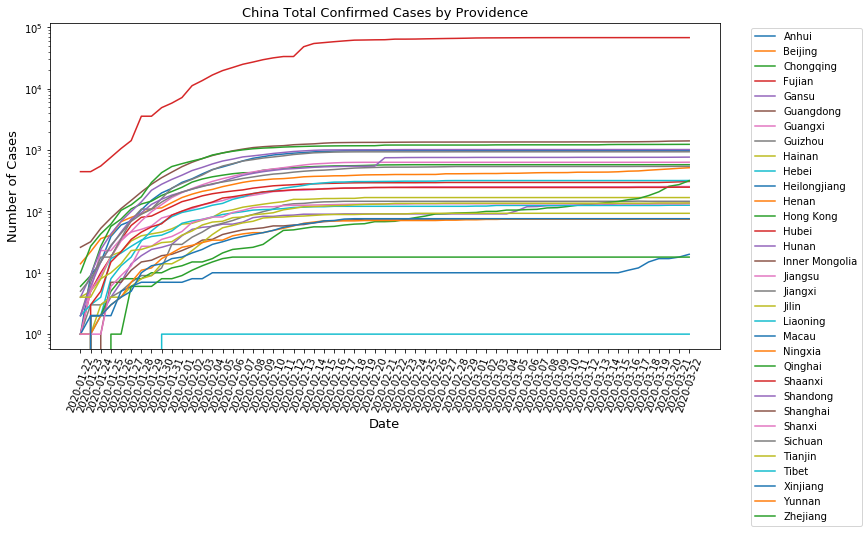

In [129]:
# train_china.groupby('Province/State').agg({'Date':['count']}), all entries have 61 dates.
train_china_trim = train_china[['Province/State', 'Date', 'ConfirmedCases', 'Fatalities']]

train_china_trim.set_index('Date', inplace = True)

unique_china_provinces = train_china_trim['Province/State'].unique()
# I am sure there is a better way of doing the below, but can't think of it for now
china_province_confirmedCases = pd.DataFrame(index = train_china_trim.index.to_list())

for province in unique_china_provinces:
    temp_df = train_china_trim[train_china_trim['Province/State'] == province][['ConfirmedCases']]
    temp_df.rename(columns = {'ConfirmedCases' : province}, inplace = True)
    china_province_confirmedCases = pd.concat([china_province_confirmedCases, temp_df], axis = 1, sort = True)

plt.figure(figsize = (12,6))
plt.plot(china_province_confirmedCases)
plt.yscale('log')
plt.title('China Total Confirmed Cases by Providence', size = 13)
plt.ylabel('Number of Cases', size = 13)
plt.xlabel('Date', size = 13)
plt.xticks(rotation = 70)
plt.legend(china_province_confirmedCases.columns, bbox_to_anchor = (1.04, 1))
plt.show()

This plot is not very insightful unfortunately.  With the sheer number of lines and districts in China, it is hard to make any specific conclusions.  Looking at the overall shape of the data, the vast majority of the providence confirmed cases have flattened in China.  If we look at China's total confirmed illness and fatalities, it looks as if the number is flattening nicely.